In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import snowFun
import dask.array
import sklearn
from sklearn.linear_model import LinearRegression
# %matplotlib widget

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")


# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [2]:
### choose if you want to do only the 45 validation glaciers
validation_only = 1

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

### get list of all the glaciers for which we have calculated the snow covered fractions
# select which rgis to analyze
if validation_only:
    folder_sca = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation', 'Band SCFs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_sca = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Band SCFs')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# load rgi names that have been saved to the classified folder
rgis_to_analyze = list(set( [ i[3:17] for i in os.listdir(folder_sca) if i!='merged.vrt' ] ))
rgis_to_analyze.sort()

In [1]:
skip = 0
for i in range(len(rgis_to_analyze)):
#     if i>0: continue
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]
    
#     # options for skipping
#     if (i+1)<308:continue #option to skip, NEED TO GO BACK TO 241, 277, 280, 290, 291
    
    if rgiid != "RGI60-01.09656": continue ##09162 08989
#     if i!=267:continue
#     if i not in [30]: continue
#     if rgiid == "RGI60-01.09162": skip=0
#     if skip: continue

    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area']
    
    # print progress
    print(f"\nStarting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga.values[0]} km2")
#     print(rgi_gdf[rgi_gdf['RGIId']==rgiid])
    
    # open the snow fraction dataframes
    if not os.path.exists(os.path.join(folder_sca, f"S2_{rgiid}_snow.csv")):
        print('Skipping')
        continue
    df_snow = pd.read_csv(os.path.join(folder_sca, f"S2_{rgiid}_snow.csv")).rename(columns={'Unnamed: 0':"band_n"}).set_index('band_n')
    df_observed = pd.read_csv(os.path.join(folder_sca, f"S2_{rgiid}_observed.csv")).rename(columns={'Unnamed: 0':"band_n"}).set_index('band_n')

    # define the columns that we will be manipulating (ie not the z_min, z_max, etc...)
    meta_columns = ["z_min", "z_max", "total_pixels"]
    data_cols = df_snow.columns.difference(meta_columns)
    
    ### these dataframes come in at 10m band resolution. we can "resample" to 20m resolution here (if we want)
    resample_to_20m = 0
    if resample_to_20m:
        # first make sure that we have an even number of rows
        if len(df_snow)%2 == 1: # if the length is odd

            # drop either first or last row, making sure that our bands are centered around the 105s (eg 1295-1315)
            if np.nanmean(df_snow['z_min'][0:1])%20==5: # this idicates we need to drop first row
                df_snow = df_snow.iloc[1:]
                df_observed = df_observed.iloc[1:]
            else:
                df_snow = df_snow.iloc[:-1]
                df_observed = df_observed.iloc[:-1]
        
        # indicate which columns should be summed
        cols_to_sum = df_snow.columns.difference(['z_min','z_max'])

        # then, create column to indicate which rows should be paired
        df_snow['pair'] = (df_snow.index-1) // 2 
        df_observed['pair'] = (df_snow.index-1) // 2 

        # get the z_min, z_max of new zones
        z_min_new = df_snow['z_min'].values[0::2]
        z_max_new = df_snow['z_max'].values[1::2]

        # sum the rows
        df_snow = df_snow.groupby('pair')[cols_to_sum].sum()
        df_observed = df_observed.groupby('pair')[cols_to_sum].sum()

        # add z_min, z_max
        df_snow['z_min']=z_min_new
        df_snow['z_max']=z_max_new
        df_observed['z_min']=z_min_new
        df_observed['z_max']=z_max_new
        
        # reset our index
        df_snow["band_n"] = df_snow.index+1
        df_observed["band_n"] = df_observed.index+1
        df_snow=df_snow.set_index('band_n')
        df_observed.set_index('band_n')
     

    # create series to link ela band # to band elevation
    bands_zs = (df_snow['z_min']+df_snow['z_max'])/2
    
    # calculate the fraction of each band that was observed in each date
    df_observed_frac = df_observed[data_cols].divide(df_observed["total_pixels"], axis=0)
    
    # calculate fraction of each band that was snow (divide n_snow by n_observed)
    df_snow_frac = df_snow[data_cols].divide(df_observed[data_cols])#, axis=0)
    
    # calculate the fraction of the entire glacier surface that is visible on each date
    df_observed_frac_glacier = df_observed[data_cols].sum(axis=0) / df_observed['total_pixels'].sum()
    
    # calculate the aar on each date (based on observable surface)
    df_aars = df_snow[data_cols].sum(axis=0) / df_observed[data_cols].sum(axis=0)
    # there are instances where a large portion of the ablation zone is nan (mostly debris cover). we should do
    # some interpolatino or something before calculating aar. eg fill in accumulation above the ela, ablation below
    
    # transition to numpy arrays for a bit. snow fractions >=0.5 become 1 (accumulation zone)
    # everything <0.5 becomes 0 (ablation)
    np_accumulation = df_snow_frac.copy()
    np_accumulation[np_accumulation>=0.5] = 1
    np_accumulation[np_accumulation<0.5] = 0
    
    # Define a kernel that sums the next 5 (4,3,2,1...) values along the 2nd dimension
    kernel5 = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0])
    kernel4 = np.array([1, 1, 1, 1, 0, 0, 0])
    kernel3 = np.array([1, 1, 1, 0, 0])
    kernel2 = np.array([1, 1, 0])
    kernel1 = np.array([1,])
    
    # apply these kernels, find elevation bands that are the start of 5 accumulation bands in a row (or 4,3,2,1)
    all_elas_5 = (np.apply_along_axis(lambda x: np.convolve(x, kernel5, mode='same'), axis=0, arr=np_accumulation))==5
    all_elas_4 = (np.apply_along_axis(lambda x: np.convolve(x, kernel4, mode='same'), axis=0, arr=np_accumulation))==4
    all_elas_3 = (np.apply_along_axis(lambda x: np.convolve(x, kernel3, mode='same'), axis=0, arr=np_accumulation))==3
    all_elas_2 = (np.apply_along_axis(lambda x: np.convolve(x, kernel3, mode='same'), axis=0, arr=np_accumulation))==2
    all_elas_1 = (np.apply_along_axis(lambda x: np.convolve(x, kernel3, mode='same'), axis=0, arr=np_accumulation))==1

    # so the lowest elevation point in each time that is equal to 5 (4,3,2,1) will be the ela
    first_elas_5 = np.argmax(all_elas_5, axis=0).astype(float)
    first_elas_4 = np.argmax(all_elas_4, axis=0).astype(float)
    first_elas_3 = np.argmax(all_elas_3, axis=0).astype(float)
    first_elas_2 = np.argmax(all_elas_3, axis=0).astype(float)
    first_elas_1 = np.argmax(all_elas_3, axis=0).astype(float)
    
    # make sure that if a column has all 0s then we put nan, to allow filling in
    first_elas_5[(all_elas_5.sum(axis=0)==0)] = np.nan
    first_elas_4[(all_elas_4.sum(axis=0)==0)] = np.nan
    first_elas_3[(all_elas_3.sum(axis=0)==0)] = np.nan
    first_elas_2[(all_elas_2.sum(axis=0)==0)] = np.nan
    first_elas_1[(all_elas_1.sum(axis=0)==0)] = np.nan
    
    # get the final elas, by first taking from 5, then 4, then 3
    final_elas = first_elas_5
    final_elas[np.isnan(final_elas)] = first_elas_4[np.isnan(final_elas)]
    final_elas[np.isnan(final_elas)] = first_elas_3[np.isnan(final_elas)]
#     final_elas[np.isnan(final_elas)] = first_elas_2[np.isnan(final_elas)]
#     print(np.count_nonzero(~np.isnan(final_elas)))
#     final_elas[np.isnan(final_elas)] = first_elas_1[np.isnan(final_elas)]
#     print(np.count_nonzero(~np.isnan(final_elas)))
    
    # lastly, if we still have no ela (the entire glacier is ablation) we'll put the highest elevation band as the ela
    # we should find some way to flag this, to make it more clear
    final_elas[np.isnan(final_elas)] = len(bands_zs)-1
    
#     fig,axs = plt.subplots(1,2, figsize=(10,5))
#     axs[0].imshow(df_snow_frac, vmin=0, vmax=1, cmap="RdBu")
#     axs[1].imshow(df_snow_frac, vmin=0, vmax=1, cmap="RdBu")
#     axs[1].plot(final_elas, c='yellow')
#     plt.tight_layout()
    
    # now that we have our elas for each time step, lets format into a df with date, ela
    ela_df = pd.DataFrame({'date':data_cols, "ela_band":(final_elas+1).astype(int)})
    ela_df['ela'] = [bands_zs[int(i+1)] for i in final_elas]
    ela_df['fraction_observed'] = df_observed_frac_glacier.values
    ela_df['aar'] = df_aars.values
    
    # add a datetime column, doy
    ela_df['date_dt'] = [datetime.strptime(i, "%Y-%m-%d") for i in ela_df['date'] ]
    ela_df['doy'] = [i.timetuple().tm_yday for i in ela_df['date_dt'] ]
    ela_df['year'] = [i.year for i in ela_df['date_dt'] ]
    
    
    if make_figures:
        # make color scheme
        colors_5 = ['red','orange','yellow','green','blue']
        colors = [colors_5[i-2018] for i in ela_df['year']]

        # plot the glacier hypsometry
        plt.figure()
        plt.scatter(df_snow['z_min'],df_snow['total_pixels']/np.nansum(df_snow['total_pixels']))
        plt.title("Glacier Hypsometry")

        # plot the 'ideal' ela-aar relationship
        plt.figure()
        plt.grid()
        plt.scatter(ela_df['ela'], ela_df['aar'], c=colors)
        plt.title("ELA-AAR relationship")

        # plot full timeseries of ela, aar
        fig,axs_save = plt.subplots(2,1, figsize=(12,6))
        axs_save[0].scatter(ela_df['date_dt'],ela_df['ela'], c=colors)
        axs_save[1].scatter(ela_df['date_dt'],ela_df['aar'], c=colors)
        fig.autofmt_xdate()
        axs_save[0].grid()
        axs_save[1].grid()
        axs_save[0].set_ylabel('ELA')
        axs_save[1].set_ylabel('AAR')
        for y in [2018,2019,2020,2021,2022]:
            axs_save[0].axvspan(f'{y}-07-01', f'{y}-12-01', zorder=-1, color='whitesmoke')
            axs_save[1].axvspan(f'{y}-07-01', f'{y}-12-01', zorder=-1, color='whitesmoke')

        # plot doy timeseries of ela, aar, coloring by year
        fig,axs = plt.subplots(2,1, figsize=(12,6))
        axs[0].scatter(ela_df['doy'],ela_df['ela'], c=colors)
        axs[1].scatter(ela_df['doy'],ela_df['aar'], c=colors)
        fig.autofmt_xdate()
        axs[0].grid()
        axs[1].grid()
        axs[0].set_ylabel('ELA')
        axs[1].set_ylabel('AAR')
        axs[1].set_xlabel('Day of Year')
    
    # now for each year, get the maximum ela
    annual_best = []
    for y in [2018,2019,2020,2021,2022]:
        
        # decide which of the columns you are going to want to save
        cols_to_save = ['date', 'ela', 'fraction_observed', 'aar']
        
        # subset to this year. note we only consider obs in the july-october time frame
        all_elas_this_year = ela_df[ (ela_df['date']>=f'{y}-01-01') & (ela_df['date']<f'{y}-12-30')]
        elas_this_year = ela_df[ (ela_df['date']>=f'{y}-07-01') & (ela_df['date']<f'{y}-11-01')]
        
        # remove dates with <90% obs
        elas_this_year = elas_this_year[elas_this_year['fraction_observed']>=0.9]
        
        # if len=0, we have no good data so we save a null point
        n_obs = len(elas_this_year)
        if n_obs==0:
            annual_best.append(pd.Series({"date":f"{y}-01-01", "ela":-9999, 'fraction_observed':-9999, 'aar':-9999}))
        
        # else we decide which the best of the elas is and save that info
        else:
            
            found_a_good_one = 0
            
            while found_a_good_one==0:
                
                # get the maximum ela
                ela_max = np.nanmax(elas_this_year['ela'])

                # get all the dates that had this ela
                ela_max_all = elas_this_year[elas_this_year['ela']==ela_max]

                # we'll take the one that has the minimum aar to be the 'best' estimate
                # for example, if the ela is well above the glacier, there are likely many dates with the same ela found
                ela_max_best = ela_max_all.loc[ela_max_all['aar'].idxmin()]


                ### gotta make sure that this is not an outlier in ELA or AAR
                # first grab all obs in the 15-30 day preceding window
                # (due ot temporal smoothing we might have info b eing shared within past 15 days that we want to avoid)
                obs_past_30 = all_elas_this_year[all_elas_this_year['doy']>=ela_max_best['doy']-30]
                obs_past_30 = obs_past_30[obs_past_30['doy']<ela_max_best['doy']-5]

                # if there are no other obs in the past 30 days, we just need to trust that this is real i guess
                if len(obs_past_30)==0:
                    found_a_good_one = 1

                else:

                    # line of best fit to these obs (predict ela from doy)
                    X = obs_past_30['doy'].values.reshape(-1, 1)
                    y = obs_past_30['ela']
                    y2 = obs_past_30['aar']
                    bestfit = LinearRegression().fit(X, y)

                    # predict the ela on this date from that fit
                    pred = bestfit.predict(np.array(ela_max_best['doy']).reshape(-1, 1))

                    # calculate difference
                    ela_diff = ela_max_best['ela']-pred
                    print(f"Predicted:{pred} Observed:{ela_max_best['ela']}")

                    # if we within a reasonable range, then we say this is a good observation and save it
                    if ela_diff<=200:
                        found_a_good_one = 1
                        
                    # otherwise, we discard this observation and find a new one
                    else:
                        bad_date = ela_max_best['date']
                        elas_this_year = elas_this_year[elas_this_year['date']!=bad_date]
                        all_elas_this_year = all_elas_this_year[all_elas_this_year['date']!=bad_date]
                
            if make_figures:
                print(ela_max_best['date'])
                print()

                # add vertical line to figure on this date
                axs_save[0].vlines([ela_max_best['date_dt']], bands_zs.values[0], bands_zs.values[-1])
                axs_save[1].vlines([ela_max_best['date_dt']], 0, 1)
            
            # save this data
            annual_best.append(ela_max_best[cols_to_save])
    
    # also save the annual best dates to file
    save_df = pd.DataFrame(annual_best) 
    save_df['RGIId'] = [rgiid for i in range(len(save_df))]
    
    path_df_all = os.path.join(folder_save, 'Annual AAs', 'csv', f"S2_{rgiid}_2018_2022_annual_AAs.csv")
    save_df.to_csv(path_df_all, index=False)
    print(save_df.head())

    break
    

NameError: name 'rgis_to_analyze' is not defined

2018-09-17
2019-08-18
2020-09-11
2021-08-19
2022-08-10


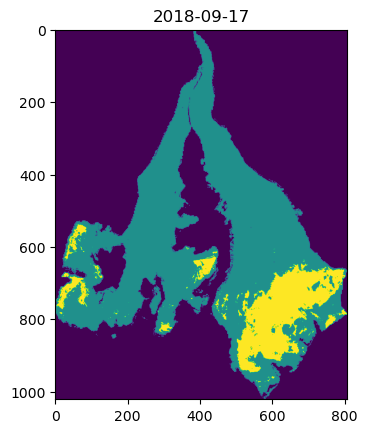

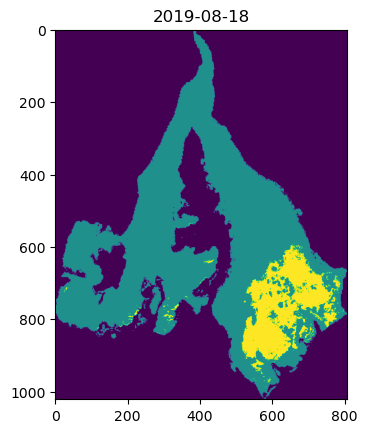

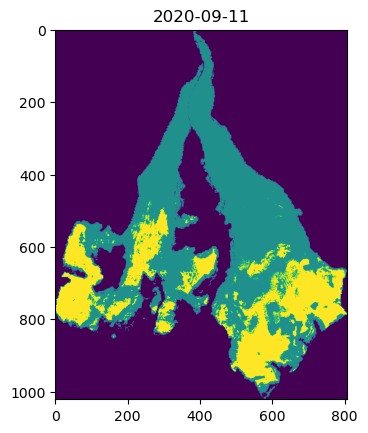

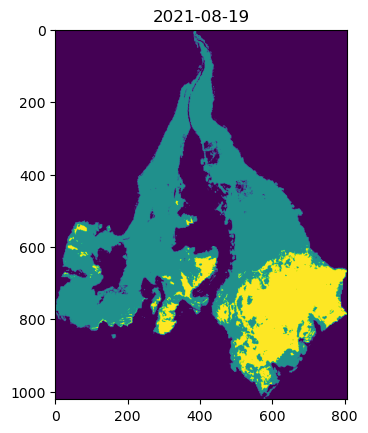

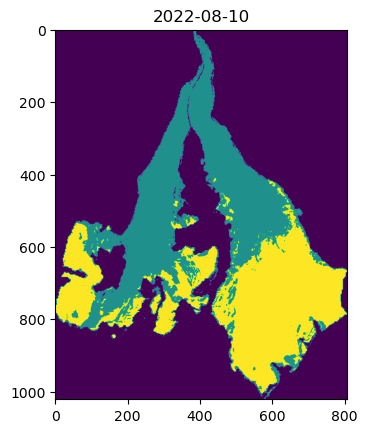

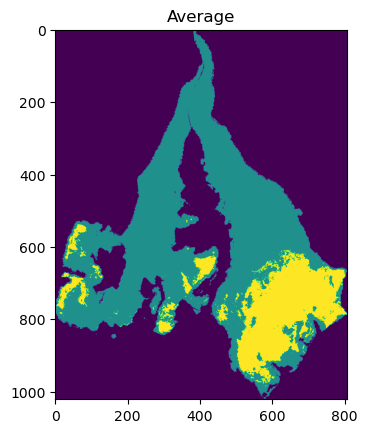

In [4]:

### make an image showing each end of year map
# set folder paths, etc...
if validation_only:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# function to format metadata and attributes
def format_xr_to_save(xr_da):
    xr_da.attrs["res"] = (10,10)
    xr_da.attrs["crs"] = "EPSG:3338"
    xr_da.attrs["transform"] = [10,0,0,0,-10,0]
    xr_da.attrs["_FillValue"] = 0
    xr_da.attrs["long_name"] = rgiid
    xr_da.attrs["description"] = "0: nan, 1: ablation, 2: accumulation"
    xr_da.name = "accumulation_area"

    xr_da.x.attrs["units"] = "meters"
    xr_da.y.attrs["units"] = "meters"
    xr_da.x.attrs["long_name"] = 'x'
    xr_da.y.attrs["long_name"] = 'y'

    return xr_da

# one year at a time, get the snow distributions
all_maps = []
i=0
for s in annual_best:
    i+=1
    # get date
    d = s['date']

    # skip the null years
    if d[5:7]=='01': continue
    print(d)

    # open the snow distribution map
    path_open = os.path.join(folder_save, 'Daily AAs', f"S2_{rgiid}_{d[:4]}_daily_AAs_smoothed.nc")
    snow = xr.open_dataset(path_open, chunks={'time':1})['class'].sel(time=d)
    all_maps.append(snow)
    
    plt.figure()
    plt.imshow(snow)
    plt.title(d)

# format to save maps as long as there is usable imagery
if len(all_maps)>0:
    
    # create snow distribution products
    all_maps = xr.concat(all_maps, dim='time')
    average_map = all_maps.median('time', skipna=True).astype('uint8')#+glacier_mask
    save_xr_all = format_xr_to_save(all_maps.astype('uint8'))
    save_xr_avg = format_xr_to_save(average_map)

    # specify compression/encoding
    encoding = {"accumulation_area":{"zlib": True}}#, "spatial_ref":{"zlib": False}}

    # specify paths
    path_xr_all = os.path.join(folder_save, 'Annual AAs', f"S2_{rgiid}_2018_2022_annual_AAs.nc")
    path_xr_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.nc")
    path_tif_avg = os.path.join(folder_save, 'Average AAs', f"S2_{rgiid}_2018_2022_average_AA.tif")
    
    # save
    save_xr_all.to_netcdf(path_xr_all, encoding=encoding)
    save_xr_avg.to_netcdf(path_xr_avg, encoding=encoding)
    save_xr_avg.rio.to_raster(raster_path=path_tif_avg, encoding=encoding)
    
    plt.figure()
    plt.imshow(average_map)
    plt.title("Average")

In [5]:
# lastly, go through all the saved csvs, make a master csv with rgiid, median ela
all_files = [ i for i in os.listdir(os.path.join(folder_save, 'csv')) if i[-3:]=='csv' ]

all_rgis = []
all_elas = []
all_aars = []

for f in all_files:
    
    # open
    df = pd.read_csv(os.path.join(folder_save, 'Annual AAs', 'csv', f))
    
    # get rgi
    all_rgis.append( f[3:17] )
    
    # get rid of the 'bad' years
    df = df[df['ela']>0]
    
    # get median ela, aar
    all_elas.append( np.nanmedian(df['ela']) )
    all_aars.append( np.nanmedian(df['aar']) )

# save everything
bulk_df = pd.DataFrame({'rgiid':all_rgis, 'ela':all_elas, 'aar':all_aars}) 
bulk_df.head()
# bulk_df.to_csv(os.path.join(folder_save, 'Region_04_2018_2022.csv'), index=False)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\Derived products\\S2\\Validation\\csv'